In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('seaborn-v0_8')  

In [3]:
df = pd.read_csv("admission.csv")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [52]:
# Compute Summary Statistics

summary_stats = df.describe(include='all')
summary_stats.loc['variance'] = df.var()
summary_stats.loc['range'] = df.max() - df.min()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
             Serial No.   GRE Score  TOEFL Score  University Rating  \
count       497.000000  497.000000   497.000000         497.000000   
mean        250.366197  316.583501   107.259557           3.122736   
std         144.567635   11.237070     6.036101           1.140806   
min           1.000000  290.000000    92.000000           1.000000   
25%         126.000000  308.000000   103.000000           2.000000   
50%         250.000000  317.000000   107.000000           3.000000   
75%         375.000000  325.000000   112.000000           4.000000   
max         500.000000  340.000000   120.000000           5.000000   
variance  20899.801113  126.271743    36.434510           1.301438   
range       499.000000   50.000000    28.000000           4.000000   

                 SOP         LOR        CGPA    Research  Chance of Admit  
count     497.000000  497.000000  497.000000  497.000000       497.000000  
mean        3.379276    3.492958    8.582334    0.563380

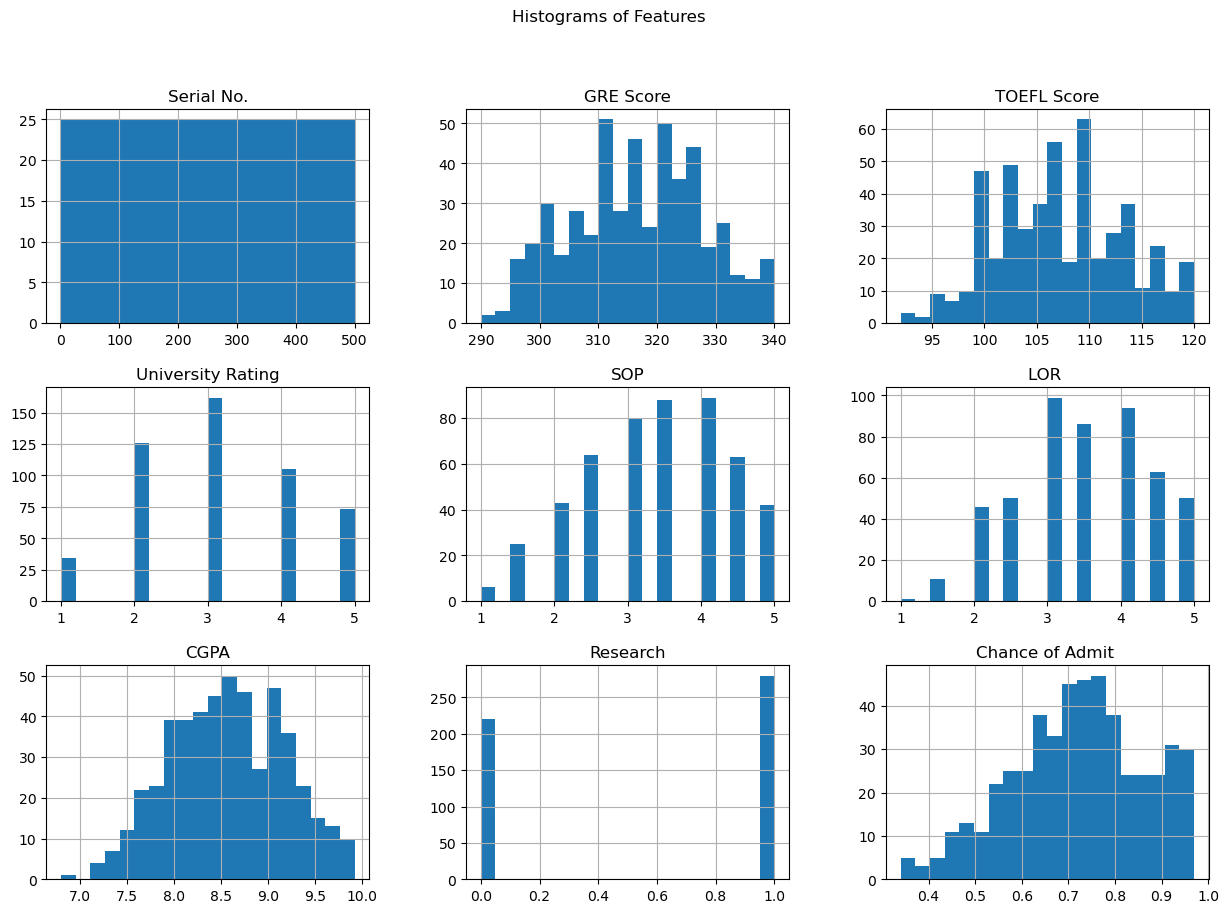

In [44]:
# Data Visualization
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Features')
plt.show()

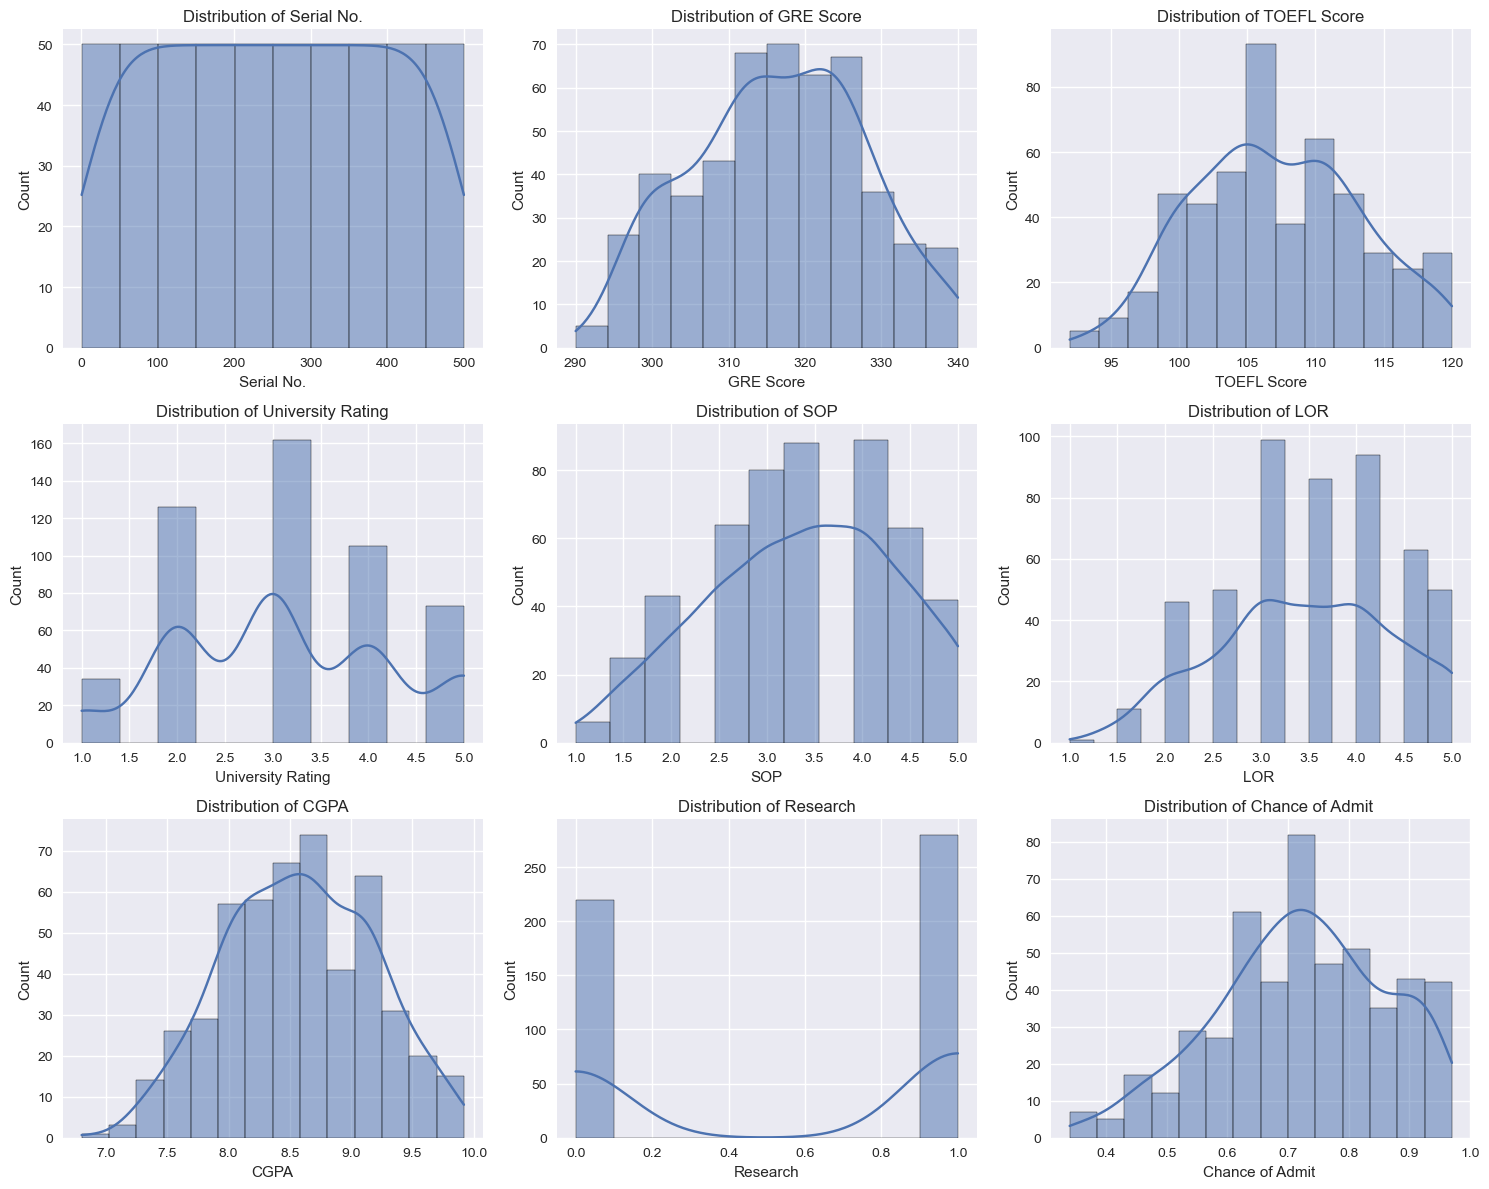

In [4]:
def plot_feature_distributions(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4*n_rows))
    
    for i, column in enumerate(numeric_columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data=df, x=column, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

plot_feature_distributions(df)


In [45]:
# Data Cleaning
# Convert columns to numeric where possible
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values with column mean
df.fillna(df.mean(), inplace=True)

print(df)


     Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0             1        337          118                  4  4.5   4.5  9.65   
1             2        324          107                  4  4.0   4.5  8.87   
2             3        316          104                  3  3.0   3.5  8.00   
3             4        322          110                  3  3.5   2.5  8.67   
4             5        314          103                  2  2.0   3.0  8.21   
..          ...        ...          ...                ...  ...   ...   ...   
495         496        332          108                  5  4.5   4.0  9.02   
496         497        337          117                  5  5.0   5.0  9.87   
497         498        330          120                  5  4.5   5.0  9.56   
498         499        312          103                  4  4.0   5.0  8.43   
499         500        327          113                  4  4.5   4.5  9.04   

     Research  Chance of Admit   
0           1    

In [8]:
def clean_data(df):
    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Remove duplicates
    df_cleaned = df.drop_duplicates()
    print(f"\nRows removed due to duplicates: {len(df) - len(df_cleaned)}")
    
    return df_cleaned

In [46]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

<Axes: >

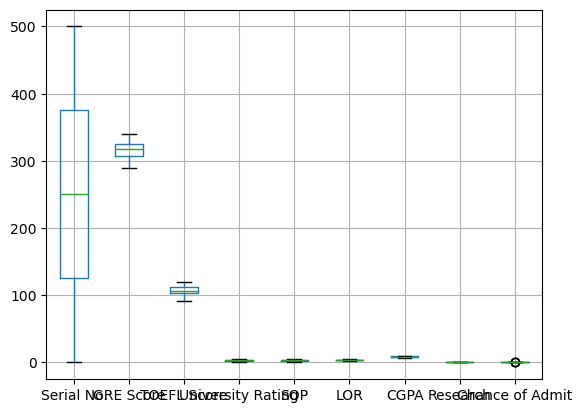

In [54]:
df.boxplot()

In [47]:
# Remove outliers using the IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [57]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('Chance of Admit', axis=1)),
 columns=df.columns[:-1])

In [49]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True)

In [50]:
# Strip any leading or trailing spaces from the column names
df.columns = df.columns.str.strip()

# 'Chance of Admit' is the column name for the target variable
X = df.drop('Chance of Admit', axis=1)
y = df['Chance of Admit']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def transform_data(df):
    # Create binary target variable (1 if chance > 0.8, 0 otherwise)
    df['high_chance'] = (df['Chance of Admit '] > 0.8).astype(int)
    
    # Select features for modeling
    features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']
    X = df[features]
    y = df['high_chance']
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, features

In [6]:
def build_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print model performance
    print("\nModel Performance:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return model, X_test, y_test

In [9]:
print("\nExecuting Data Pipeline:")
df_cleaned = clean_data(df)
X_scaled, y, features = transform_data(df_cleaned)
model, X_test, y_test = build_model(X_scaled, y)


Executing Data Pipeline:

Missing Values:
Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

Rows removed due to duplicates: 0

Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        73
           1       0.90      1.00      0.95        27

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.96       100
weighted avg       0.97      0.97      0.97       100



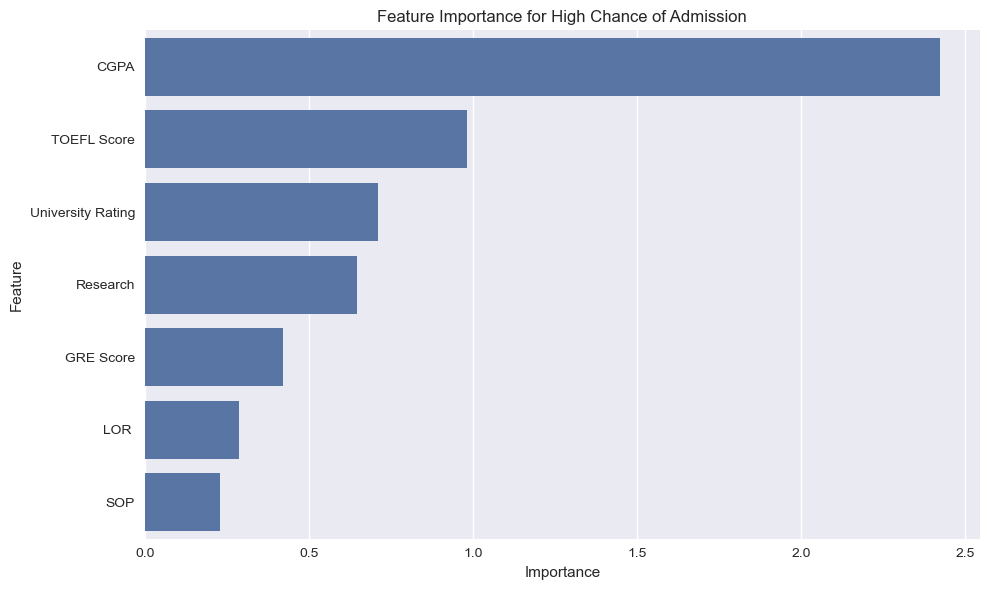

In [10]:
def plot_feature_importance(model, features):
    plt.figure(figsize=(10, 6))
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': abs(model.coef_[0])
    })
    importance = importance.sort_values('Importance', ascending=False)
    
    sns.barplot(data=importance, x='Importance', y='Feature')
    plt.title('Feature Importance for High Chance of Admission')
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, features)